In [3]:
import sys
print(sys.version)

#what is the current working directory?
import os
os.getcwd()

#Dependencies
import numpy as np
import pandas as pd
import re

from datetime import date, datetime

#set df scrolling
pd.set_option("display.max.columns",None)
#set df precision to 2 decimals for now...
pd.set_option("display.precision",2)
pd.set_option('display.max_rows',500)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
enc = OneHotEncoder(handle_unknown = 'ignore')
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics


3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]


In [4]:
#Import Train Data
dfpath_train = "../01_data/training_v2.csv"
dfpath_test = "../01_data/unlabeled.csv"

df_train = pd.read_csv(dfpath_train)
print(df_train.shape)

df_test = pd.read_csv(dfpath_test)
print(df_test.shape)

target_col = 'hospital_death'

(91713, 186)
(39308, 186)


# Data Cleaning

In [5]:
# Clean up alphanumeric columns by putting in all lowercase
#1.  change to all lowercase
df_train = df_train.apply(lambda x: x.astype(str).str.lower() if(x.dtype == 'object') else x)
df_train.head(2)

df_test = df_test.apply(lambda x: x.astype(str).str.lower() if(x.dtype == 'object') else x)
df_test.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,NaN,56.0,21.1,0,caucasian,m,180.3,emergency department,accident & emergency,1105,admit,neuro icu,0.10,0,68.6,3.7,301.0,405.01,0,0.0,NaN,19.0,0.67,NaN,2.0,5.0,0.0,1.0,276.0,105.0,42.0,0.0,57.0,NaN,NaN,NaN,NaN,5.0,134.0,36.6,1121.13,0.0,4.7,NaN,NaN,74.0,51.0,74.0,51.0,100.0,78.0,NaN,NaN,86.0,60.0,86.0,60.0,20.0,8.0,100.0,96.0,NaN,NaN,121.0,79.0,121.0,79.0,37.1,36.6,NaN,NaN,55.0,51.0,55.0,51.0,88.0,84.0,NaN,NaN,68.0,60.0,68.0,60.0,18.0,8.0,100.0,98.0,NaN,NaN,91.0,79.0,91.0,79.0,36.6,36.6,3.7,3.7,NaN,NaN,19.0,19.0,9.3,9.3,0.67,0.67,276.0,167.0,24.0,24.0,13.8,13.8,42.0,42.0,NaN,NaN,NaN,NaN,223.0,223.0,4.8,4.8,135.0,134.0,4.7,4.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neurological,neurologic
1,5,130737,178,NaN,NaN,19.5,1,caucasian,f,145.0,operating room,operating room / recovery,

In [6]:
#drop readmission status as they are all the same
df_train = df_train.drop(['readmission_status'], axis = 1)
df_test = df_test.drop(['readmission_status'], axis = 1)

In [7]:
#leave out gender and ethnicity to avoid bias)
df_train = df_train.drop(['gender','ethnicity'], axis = 1)
df_train.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,180.3,floor,floor,92,admit,cticu,5.42e-01,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,sepsis,cardiovascular
1,114252,59342,81,0,77.0,27.42,0,160.0,floor,floor,90,admit,med-surg icu,9.28e-01,70.2,NaN,108.0,203.01,0,0.0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,3

In [8]:
#leave out gender and ethnicity to avoid bias)
df_test = df_test.drop(['gender','ethnicity'], axis = 1)
df_test.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,NaN,56.0,21.10,0,180.3,emergency department,accident & emergency,1105,admit,neuro icu,1.04e-01,68.6,3.7,301.0,405.01,0,0.0,NaN,19.0,0.67,NaN,2.0,5.0,0.0,1.0,276.0,105.0,42.0,0.0,57.0,NaN,NaN,NaN,NaN,5.0,134.0,36.6,1121.13,0.0,4.7,NaN,NaN,74.0,51.0,74.0,51.0,100.0,78.0,NaN,NaN,86.0,60.0,86.0,60.0,20.0,8.0,100.0,96.0,NaN,NaN,121.0,79.0,121.0,79.0,37.1,36.6,NaN,NaN,55.0,51.0,55.0,51.0,88.0,84.0,NaN,NaN,68.0,60.0,68.0,60.0,18.0,8.0,100.0,98.0,NaN,NaN,91.0,79.0,91.0,79.0,36.6,36.6,3.7,3.7,NaN,NaN,19.0,19.0,9.3,9.3,0.67,0.67,276.0,167.0,24.0,24.0,13.8,13.8,42.0,42.0,NaN,NaN,NaN,NaN,223.0,223.0,4.8,4.8,135.0,134.0,4.7,4.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neurological,neurologic
1,5,130737,178,NaN,NaN,19.50,1,145.0,operating room,operating room / recovery,1043,admit,med-surg icu,2.31e-01,41.0,NaN,217.0,1502.02,

In [9]:
#Handle Nan Values:  Categorical
#How many NA records are in each column?
df_train.isna().sum()

encounter_id                         0
patient_id                           0
hospital_id                          0
hospital_death                       0
age                               4228
bmi                               3429
elective_surgery                     0
height                            1334
hospital_admit_source                0
icu_admit_source                     0
icu_id                               0
icu_stay_type                        0
icu_type                             0
pre_icu_los_days                     0
weight                            2720
albumin_apache                   54379
apache_2_diagnosis                1662
apache_3j_diagnosis               1101
apache_post_operative                0
arf_apache                         715
bilirubin_apache                 58134
bun_apache                       19262
creatinine_apache                18853
fio2_apache                      70868
gcs_eyes_apache                   1901
gcs_motor_apache         

In [10]:
#Example:d1 lactate is important, but contains A LOT of nan values / Replace the Nan's with a value outside of the recorded values
#http://repository.ajou.ac.kr/handle/201003/5041g 

print('d1_lactate_min min : ' + str(df_train['d1_lactate_min'].min()))
print('d1_lactate_min max : ' + str(df_train['d1_lactate_min'].max()))
print('d1_lactate_max min : ' + str(df_train['d1_lactate_max'].min()))
print('d1_lactate_max max: ' + str(df_train['d1_lactate_max'].max()))
print('h1_lactate_min min : ' + str(df_train['h1_lactate_min'].min()))
print('h1_lactate_min max : ' + str(df_train['h1_lactate_min'].max()))
print('h1_lactate_max min : ' + str(df_train['h1_lactate_max'].min()))
print('h1_lactate_max max: ' + str(df_train['h1_lactate_max'].max()))


#simple imputer for nan values in d1_lactate, zero is the default, OK.
constant_imputer = SimpleImputer(missing_values = np.nan, strategy = "constant")

#Fit the data, function learns the stats
df_train_imputed = pd.DataFrame(constant_imputer.fit_transform(df_train[['d1_lactate_min','d1_lactate_max','h1_lactate_min','h1_lactate_max']]))
df_test_imputed = pd.DataFrame(constant_imputer.fit_transform(df_test[['d1_lactate_min','d1_lactate_max','h1_lactate_min','h1_lactate_max']]))
# #add titles back
df_train_imputed.columns = df_train[['d1_lactate_min','d1_lactate_max','h1_lactate_min','h1_lactate_max']].columns
df_test_imputed.columns = df_test[['d1_lactate_min','d1_lactate_max','h1_lactate_min','h1_lactate_max']].columns


df_train[['d1_lactate_min','d1_lactate_max','h1_lactate_min','h1_lactate_max']] = df_train_imputed
df_train.head()

df_test[['d1_lactate_min','d1_lactate_max','h1_lactate_min','h1_lactate_max']] = df_test_imputed
df_test.head()


d1_lactate_min min : 0.4
d1_lactate_min max : 15.1
d1_lactate_max min : 0.4
d1_lactate_max max: 19.8
h1_lactate_min min : 0.4
h1_lactate_min max : 18.0195
h1_lactate_max min : 0.4
h1_lactate_max max: 18.1


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,NaN,56.0,21.10,0,180.3,emergency department,accident & emergency,1105,admit,neuro icu,1.04e-01,68.6,3.7,301.0,405.01,0,0.0,NaN,19.0,0.67,NaN,2.0,5.0,0.0,1.0,276.0,105.0,42.0,0.0,57.0,NaN,NaN,NaN,NaN,5.0,134.0,36.6,1121.13,0.0,4.7,NaN,NaN,74.0,51.0,74.0,51.0,100.0,78.0,NaN,NaN,86.0,60.0,86.0,60.0,20.0,8.0,100.0,96.0,NaN,NaN,121.0,79.0,121.0,79.0,37.1,36.6,NaN,NaN,55.0,51.0,55.0,51.0,88.0,84.0,NaN,NaN,68.0,60.0,68.0,60.0,18.0,8.0,100.0,98.0,NaN,NaN,91.0,79.0,91.0,79.0,36.6,36.6,3.7,3.7,NaN,NaN,19.0,19.0,9.3,9.3,0.67,0.67,276.0,167.0,24.0,24.0,13.8,13.8,42.0,42.0,NaN,NaN,0.0,0.0,223.0,223.0,4.8,4.8,135.0,134.0,4.7,4.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neurological,neurologic
1,5,130737,178,NaN,NaN,19.50,1,145.0,operating room,operating room / recovery,1043,admit,med-surg icu,2.31e-01,41.0,NaN,217.0,1502.02,

In [11]:
print(df_train.shape)

(91713, 183)


In [12]:
print(df_test.shape)

(39308, 183)


# Data Exploration

In [13]:
#Predictor Column
df_predictor = df_train[['hospital_death']]
df_predictor.head()

,hospital_death
0,0
1,0
2,0
3,0
4,0


In [14]:
#numeric columns
df_train_numeric = df_train._get_numeric_data()
#df_train_numeric.head()
df_train_numeric.shape

#process numeric columns
df_test_numeric = df_test._get_numeric_data()
# df_test_numeric.head()
df_test_numeric.shape

(39308, 177)

In [15]:
#categorical columns
df_train_cat = df_train.drop(df_train_numeric, axis = 1)
# df_train_cat.head()
df_train_cat.shape

df_test_cat = df_test.drop(df_test_numeric, axis = 1)
# df_test_cat.head()
df_test_cat.shape

(39308, 6)

In [16]:
#Impute for numerical columns
#for now impute zeros for all other Nan values in df

#Fit the data, function learns the stats
df_train_num_imputed = pd.DataFrame(constant_imputer.fit_transform(df_train_numeric))
df_test_num_imputed = pd.DataFrame(constant_imputer.fit_transform(df_test_numeric))
# #add titles back
df_train_num_imputed.columns = df_train_numeric.columns
df_test_num_imputed.columns = df_test_numeric.columns

df_train_numeric = df_train_num_imputed
df_train_numeric.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,66154.0,25312.0,118.0,0.0,68.0,22.73,0.0,180.3,92.0,5.42e-01,73.9,2.3,113.0,502.01,0.0,0.0,0.4,31.0,2.51,0.0,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,0.0,0.0,0.0,0.00,36.0,134.0,39.3,0.0,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,0.0,0.0,68.0,63.0,68.0,63.0,119.0,108.0,0.0,0.0,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,0.0,0.0,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,0.0,0.0,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,114252.0,59342.0,81.0,0.0,77.0,27.42,0.0,160.0,90.0,9.28e-01,70.2,0.0,108.0,203.01,0.0,0.0,0.0,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,0.0,1.0,12.7,0.0,0.0,95.0,31.0,95.0,31.0,118.0,72.0,0.0,0.0,120.0,38.0,120.0,38.0,32.0,12.0,100

In [17]:
df_test_numeric = df_test_num_imputed
df_test_numeric.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,2.0,127112.0,7.0,0.0,56.0,21.10,0.0,180.3,1105.0,1.04e-01,68.6,3.7,301.0,405.01,0.0,0.0,0.0,19.0,0.67,0.0,2.0,5.0,0.0,1.0,276.0,105.0,42.0,0.0,57.0,0.0,0.0,0.0,0.00,5.0,134.0,36.6,1121.13,0.0,4.7,0.0,0.0,74.0,51.0,74.0,51.0,100.0,78.0,0.0,0.0,86.0,60.0,86.0,60.0,20.0,8.0,100.0,96.0,0.0,0.0,121.0,79.0,121.0,79.0,37.1,36.6,0.0,0.0,55.0,51.0,55.0,51.0,88.0,84.0,0.0,0.0,68.0,60.0,68.0,60.0,18.0,8.0,100.0,98.0,0.0,0.0,91.0,79.0,91.0,79.0,36.6,36.6,3.7,3.7,0.0,0.0,19.0,19.0,9.3,9.3,0.67,0.67,276.0,167.0,24.0,24.0,13.8,13.8,42.0,42.0,0.0,0.0,0.0,0.0,223.0,223.0,4.8,4.8,135.0,134.0,4.7,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,130737.0,178.0,0.0,0.0,19.50,1.0,145.0,1043.0,2.31e-01,41.0,0.0,217.0,1502.02,1.0,0.0,0.0,0.0,0.00,0.0,4.0,6.0,0.0,4.0,0.0,60.0,0.0,0.0,53.0,0.0,0.0,0.0,0.00,37.0,0.0,37.0,843.44,0.0,0.0,0.0,0.0,65.0,31.0,65.0,31.0,73.0,60.0,0.0,0.0,108.0,53.0,108.0,53.0,33.0,16.0,99.0,90.0,0.0,0.0,148.0,83.0,1

In [18]:
#Impute for categorical columns
#simple imputer for nan values in categorical, try strategy is most_frequent
cat_imputer = SimpleImputer(missing_values = 'nan', strategy = "constant", fill_value = 'missing_value')
#Fit the data, function learns the stats
df_train_cat_imputed = pd.DataFrame(cat_imputer.fit_transform(df_train_cat))
df_test_cat_imputed = pd.DataFrame(cat_imputer.fit_transform(df_test_cat))
# #add titles back
df_train_cat_imputed.columns = df_train_cat.columns
df_test_cat_imputed.columns = df_test_cat.columns

df_train_categorical = df_train_cat_imputed
df_train_categorical['hospital_death'] = df_predictor['hospital_death']
df_train_categorical.head()




,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem,hospital_death
0,floor,floor,admit,cticu,sepsis,cardiovascular,0
1,floor,floor,admit,med-surg icu,respiratory,respiratory,0
2,emergency department,accident & emergency,admit,med-surg icu,metabolic,metabolic,0
3,operating room,operating room / recovery,admit,cticu,cardiovascular,cardiovascular,0
4,missing_value,accident & emergency,admit,med-surg icu,trauma,trauma,0


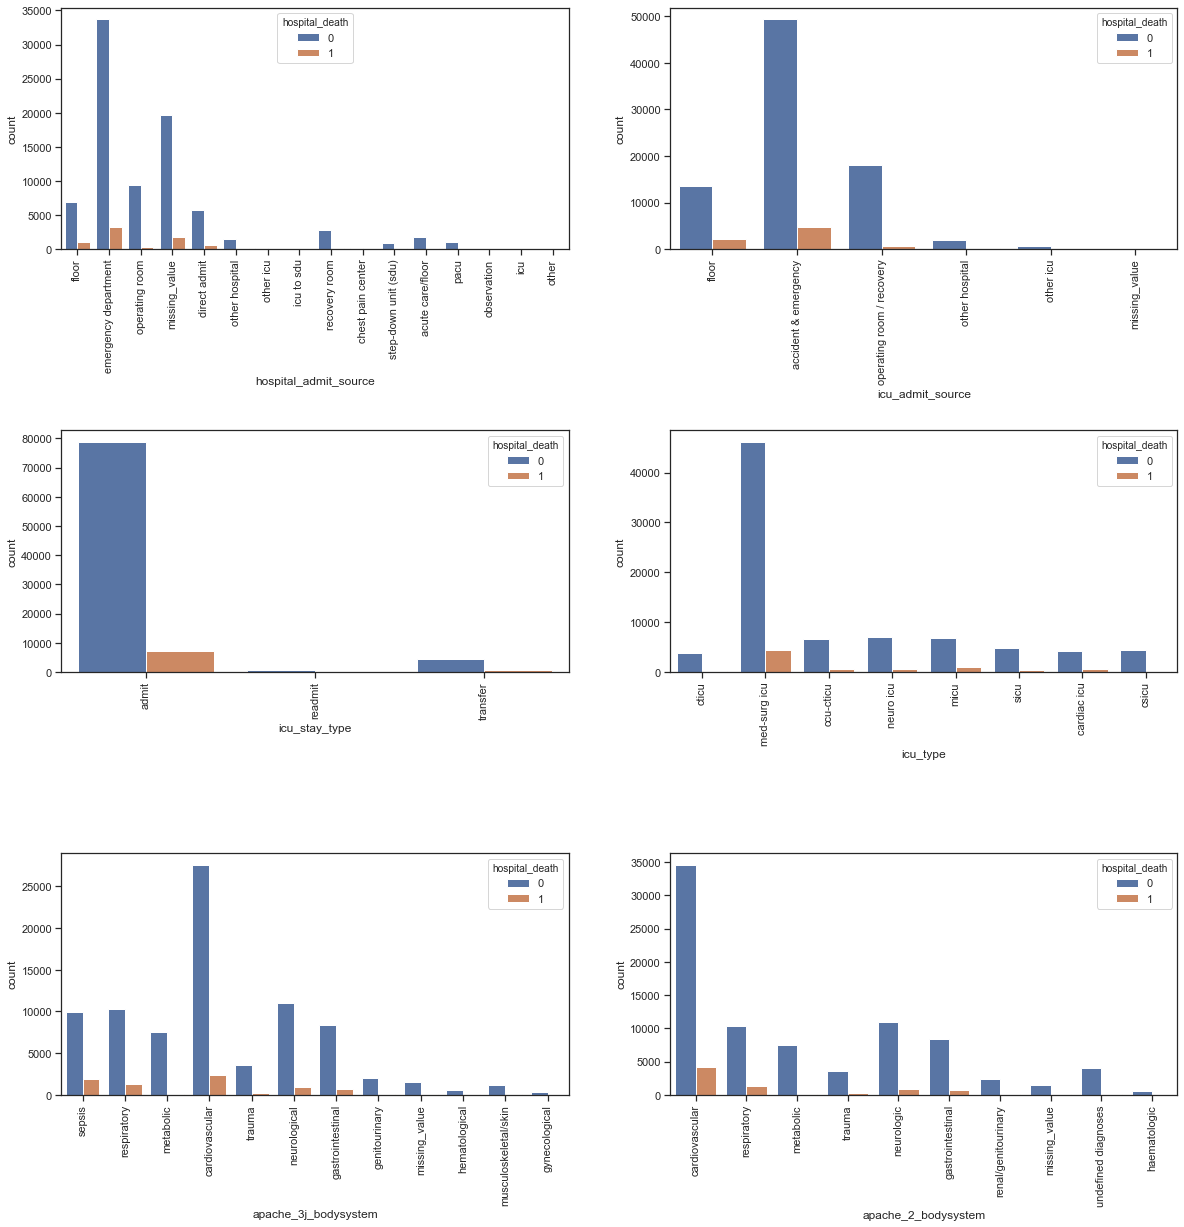

In [19]:
#Visualize Categorical Columns 
sns.set(style="ticks")
fig, ax = plt.subplots(3, 2, figsize = (20, 20))
for cat, subplot in zip(df_train_categorical.columns.values, ax.flatten()):
    sns.countplot(df_train_categorical[cat],hue = df_train_categorical['hospital_death'],ax = subplot, data = df_train_categorical)
    plt.subplots_adjust(hspace = 0.75)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
        
fig.savefig('../03_figures/Categorical_Countplot'  + (str(date.today())))

    

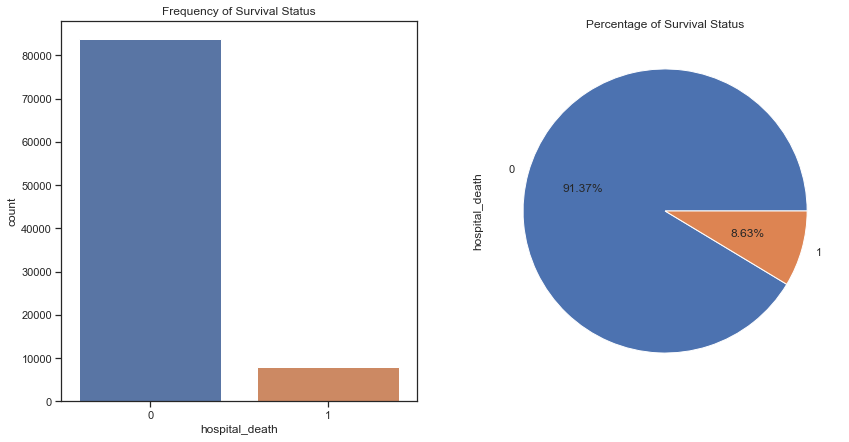

In [20]:
#How many patients in this dataset live and died?
fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='hospital_death', data = df_train, ax = axs[0])
axs[0].set_title("Frequency of Survival Status")
df_train['hospital_death'].value_counts().plot(x=None, y = None, kind = 'pie', ax = axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of Survival Status")
plt.show()

In [21]:
#Encode only the categorical columns apache2 and apache3
enc_train_df = pd.get_dummies(df_train_cat_imputed[['icu_admit_source','icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']], drop_first = True)
#enc_df.head()
print(enc_train_df.shape)

enc_test_df = pd.get_dummies(df_test_cat_imputed[['icu_admit_source','icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']], drop_first = True)
#enc_df.head()
print(enc_test_df.shape)

(91713, 34)
(39308, 34)


In [22]:
enc_test_df.head()

,icu_admit_source_floor,icu_admit_source_missing_value,icu_admit_source_operating room / recovery,icu_admit_source_other hospital,icu_admit_source_other icu,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_ccu-cticu,icu_type_csicu,icu_type_cticu,icu_type_med-surg icu,icu_type_micu,icu_type_neuro icu,icu_type_sicu,apache_3j_bodysystem_gastrointestinal,apache_3j_bodysystem_genitourinary,apache_3j_bodysystem_gynecological,apache_3j_bodysystem_hematological,apache_3j_bodysystem_metabolic,apache_3j_bodysystem_missing_value,apache_3j_bodysystem_musculoskeletal/skin,apache_3j_bodysystem_neurological,apache_3j_bodysystem_respiratory,apache_3j_bodysystem_sepsis,apache_3j_bodysystem_trauma,apache_2_bodysystem_gastrointestinal,apache_2_bodysystem_haematologic,apache_2_bodysystem_metabolic,apache_2_bodysystem_missing_value,apache_2_bodysystem_neurologic,apache_2_bodysystem_renal/genitourinary,apache_2_bodysystem_respiratory,apache_2_bodysystem_trauma,apache_2_bodysystem_undefined diagnoses
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [23]:
#Combine encoded categorical columns with the numeric columns -TRAIN
df_train = pd.concat([df_train_numeric, enc_train_df], axis = 1)
print(df_train.shape)
df_train.head()


(91713, 211)


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,icu_admit_source_floor,icu_admit_source_missing_value,icu_admit_source_operating room / recovery,icu_admit_source_other hospital,icu_admit_source_other icu,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_ccu-cticu,icu_type_csicu,icu_type_cticu,icu_type_med-surg icu,icu_type_micu,icu_type_neuro icu,icu_type_sicu,apache_3j_bodysystem_gastrointestinal,apache_3j_bodysystem_genitourinary,apache_3j_bodysystem_gynecological,apache_3j_bodysystem_hematological,apache_3j_bodysystem_metabolic,apache_3j_bodysystem_missing_value,apache_3j_bodysystem_musculoskeletal/skin,apache_3j_bodysystem_neurological,apache_3j_bodysystem_respiratory,apache_3j_bodysystem_sepsis,apache_3j_bodysystem_trauma,apache_2_bodysystem_gastrointestinal,apache_2_bodysystem_haematologic,apache_2_bodysystem_metabolic,apache_2_bodysystem_missing_value,apache_2_bodysystem_neurologic,apache_2_bodysystem_renal/genitourinary,apache_2_bodysystem_respiratory,apache_2_bodysystem_trauma,apache_2_bodysystem_undefined diagnoses
0,66154.0,25312.0,118.0,0.0,68.0,22.73,0.0,180.3,92.0,5.42e-01,73.9,2.3,113.0,502.01,0.0,0.0,0.4,31.0,2.51,0.0,3.0,6.0,0.0,4.0

In [24]:
#Combine encoded categorical columns with the numeric columns - TEST
df_test = pd.concat([df_test_numeric, enc_test_df], axis = 1)
print(df_test.shape)
df_test.head()

(39308, 211)


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,icu_admit_source_floor,icu_admit_source_missing_value,icu_admit_source_operating room / recovery,icu_admit_source_other hospital,icu_admit_source_other icu,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_ccu-cticu,icu_type_csicu,icu_type_cticu,icu_type_med-surg icu,icu_type_micu,icu_type_neuro icu,icu_type_sicu,apache_3j_bodysystem_gastrointestinal,apache_3j_bodysystem_genitourinary,apache_3j_bodysystem_gynecological,apache_3j_bodysystem_hematological,apache_3j_bodysystem_metabolic,apache_3j_bodysystem_missing_value,apache_3j_bodysystem_musculoskeletal/skin,apache_3j_bodysystem_neurological,apache_3j_bodysystem_respiratory,apache_3j_bodysystem_sepsis,apache_3j_bodysystem_trauma,apache_2_bodysystem_gastrointestinal,apache_2_bodysystem_haematologic,apache_2_bodysystem_metabolic,apache_2_bodysystem_missing_value,apache_2_bodysystem_neurologic,apache_2_bodysystem_renal/genitourinary,apache_2_bodysystem_respiratory,apache_2_bodysystem_trauma,apache_2_bodysystem_undefined diagnoses
0,2.0,127112.0,7.0,0.0,56.0,21.10,0.0,180.3,1105.0,1.04e-01,68.6,3.7,301.0,405.01,0.0,0.0,0.0,19.0,0.67,0.0,2.0,5.0,0.0,1.0,27

In [25]:
#Determine attributes most correlated to hospital deaths
#compute the correlation matrix
corr = df_train.corr()
#Only use correlation values with abs(value) >= .12

most_corr_columns = corr[abs(corr['hospital_death']) > .12]
most_corr_columns = (most_corr_columns['hospital_death']).sort_values(ascending=False)
most_corr_columns

hospital_death                   1.00
d1_lactate_min                   0.32
d1_lactate_max                   0.32
apache_4a_hospital_death_prob    0.30
apache_4a_icu_death_prob         0.27
ventilated_apache                0.23
fio2_apache                      0.22
d1_arterial_ph_max               0.20
d1_arterial_pco2_max             0.19
d1_arterial_ph_min               0.19
d1_arterial_po2_max              0.18
ph_apache                        0.18
intubated_apache                 0.17
d1_arterial_pco2_min             0.17
d1_bun_max                       0.17
h1_lactate_min                   0.16
h1_lactate_max                   0.16
paco2_for_ph_apache              0.16
paco2_apache                     0.16
d1_bun_min                       0.16
d1_heartrate_max                 0.16
d1_inr_max                       0.16
h1_inr_max                       0.16
bun_apache                       0.15
d1_arterial_po2_min              0.15
pao2_apache                      0.15
d1_inr_min  

In [26]:
most_corr = corr[most_corr_columns.index]
most_corr.head(150)

,hospital_death,d1_lactate_min,d1_lactate_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,ventilated_apache,fio2_apache,d1_arterial_ph_max,d1_arterial_pco2_max,d1_arterial_ph_min,d1_arterial_po2_max,ph_apache,intubated_apache,d1_arterial_pco2_min,d1_bun_max,h1_lactate_min,h1_lactate_max,paco2_for_ph_apache,paco2_apache,d1_bun_min,d1_heartrate_max,d1_inr_max,h1_inr_max,bun_apache,d1_arterial_po2_min,pao2_apache,d1_inr_min,h1_inr_min,d1_pao2fio2ratio_max,d1_bilirubin_max,d1_diasbp_noninvasive_min,d1_mbp_noninvasive_min,d1_diasbp_min,d1_sysbp_noninvasive_min,d1_spo2_min,d1_mbp_min,d1_sysbp_min,gcs_verbal_apache,gcs_eyes_apache,gcs_motor_apache
encounter_id,-5.24e-03,-5.90e-03,-4.58e-03,-4.48e-04,3.51e-04,-5.65e-03,-1.69e-03,-1.92e-03,-4.01e-04,-1.89e-03,-1.16e-03,-1.74e-03,-3.10e-03,-5.43e-04,2.37e-03,-1.23e-03,-1.38e-03,6.54e-04,6.54e-04,2.31e-03,-4.05e-03,-7.97e-04,-7.97e-04,1.32e-03,-3.27e-03,-1.68e-03,-6.89e-05,-6.89e-05,-2.06e-03,-1.98e-03,2.94e-04,-2.93e-04,1.29e-03,-2.79e-03,2.26e-03,5.88e-04,-1.76e-03,5.96e-03,2.75e-03,6.34e-03
patient_id,4.88e-03,9.68e-04,1.72e-03,3.69e-03,1.63e-03,-4.26e-03,-8.64e-04,-1.21e-03,-1.01e-06,-1.26e-03,7.77e-04,-1.93e-03,1.39e-03,-1.13e-03,2.31e-03,-1.60e-03,-1.63e-03,-2.75e-03,-2.75e-03,2.47e-03,1.62e-03,-6.31e-03,-6.31e-03,1.36e-03,-1.23e-03,-1.91e-03,-4.44e-03,-4.44e-03,-1.81e-03,-2.66e-03,-4.21e-03,-3.19e-03,-3.53e-03,-6.42e-03,-5.13e-04,-2.61e-03,-5.96e-03,2.61e-03,4.27e-03,5.15e-03
hospital_id,-1.25e-03,-1.92e-02,-2.54e-02,-5.17e-03,6.27e-04,3.01e-02,6.16e-03,1.95e-02,4.39e-02,1.92e-02,4.32e-02,3.57e-03,2.73e-02,4.17e-02,-1.90e-02,-4.83e-03,-6.06e-03,4.03e-04,4.03e-04,-1.81e-02,-1.15e-02,-1.86e-02,-1.86e-02,-2.37e-02,3.57e-02,4.61e-03,-2.12e-02,-2.12e-02,3.16e-02,6.15e-03,1.33e-02,3.73e-03,2.23e-02,5.18e-03,1.87e-02,1.79e-02,1.66e-02,-5.12e-04,-7.29e-03,-1.40e-02
hospital_death,1.00e+00,3.24e-01,3.23e-01,3.00e-01,2.74e-01,2.26e-01,2.20e-01,1.95e-01,1.94e-01,1.93e-01,1.76e-01,1.75e-01,1.72e-01,1.68e-01,1.65e-01,1.63e-01,1.63e-01,1.61e-01,1.61e-01,1.61e-01,1.59e-01,1.58e-01,1.58e-01,1.52e-01,1.51e-01,1.48e-01,1.45e-01,1.45e-01,1.40e-01,1.22e-01,-1.68e-01,-1.72e-01,-1.79e-01,-1.90e-01,-1.91e-01,-1.93e-01,-2.09e-01,-2.37e-01,-2.47e-01,-2.60e-01
age,5.14e-02,1.12e-03,-9.81e-04,6.65e-02,3.76e-02,6.51e-02,6.00e-02,5.53e-02,6.01e-02,5.54e-02,4.18e-02,6.13e-02,4.35e-02,6.07e-02,1.30e-01,-5.51e-03,-5.68e-03,6.21e-02,6.21e-02,1.41e-01,-8.38e-02,7.59e-02,7.59e-02,1.35e-01,2.94e-02,4.48e-02,7.70e-02,7.70e-02,2.50e-02,-2.12e-02,-1.13e-01,-7.32e-02,-1.17e-01,-3.79e-02,-3.54e-02,-7.23e-02,-3.45e-02,4.58e-02,8.51e-02,9.41e-02
bmi,-3.30e-02,2.00e-05,1.92e-03,-7.57e-03,5.58e-03,6.57e-02,4.64e-02,5.06e-02,8.30e-02,5.04e-02,1.03e-02,4.22e-02,3.74e-02,7.97e-02,4.62e-02,2.09e-03,2.30e-03,6.21e-02,6.21e-02,4.80e-02,-1.69e-02,2.27e-02,2.27e-02,3.88e-02,8.84e-03,1.04e-02,2.40e-02,2.40e-02,6.58e-03,3.04e-03,-1.55e-02,7.98e-03,-1.29e-02,3.47e-02,3.79e-03,8.16e-03,4.19e-02,1.01e-02,2.26e-03,1.26e-02
elective_surgery,-9.36e-02,-8.81e-02,-7.99e-02,-9.18e-02,-5.75e-02,1.49e-01,1.19e-01,1.39e-01,1.29e-01,1.38e-01,1.86e-01,1.37e-01,1.62e-01,1.22e-01,-1.30e-01,-2.75e-02,-2.59e-02,1.22e-01,1.22e-01,-1.32e-01,-7.08e-02,-9.53e-03,-9.53e-03,-1.14e-01,1.22e-01,1.22e-01,-7.44e-03,-7.44e-03,1.55e-01,-4.99e-02,-3.33e-02,-5.66e-02,8.70e-03,-2.86e-02,3.67e-02,1.44e-02,3.06e-02,-4.56e-03,1.92e-02,2.52e-02
height,-3.05e-02,-1.14e-02,-7.64e-03,1.42e-03,9.39e-03,1.65e-02,2.61e-02,2.65e-02,2.77e-02,2.65e-02,2.37e-02,2.39e-02,2.58e-02,2.69e-02,2.65e-02,-3.53e-03,-2.68e-03,2.29e-02,2.29e-02,2.53e-02,1.02e-02,2.26e-02,2.26e-02,2.91e-02,1.63e-02,1.57e-02,2.35e-02,2.35e-02,2.44e-02,1.91e-02,5.56e-02,3.30e-02,6.05e-02,2.04e-02,4.18e-02,4.07e-02,2.39e-02,1.62e-02,1.59e-02,1.76e-02
icu_id,9.94e-04,6.24e-03,7.94e-03,8.83e-03,-5.13e-04,3.21e-03,-9.66e-02,-7.80e-02,-4.55e-02,-7.78e-02,-5.19e-02,-1.12e-01,-7.50e-02,-3.93e-02,1.31e-02,1.12e-02,1.10e-02,-1.06e-01,-1.06e-01,6.55e-03,2.38e-03,-2.17e-03,-2.17e-03,5.09e-03,-3.25e-02,-8.85e-02

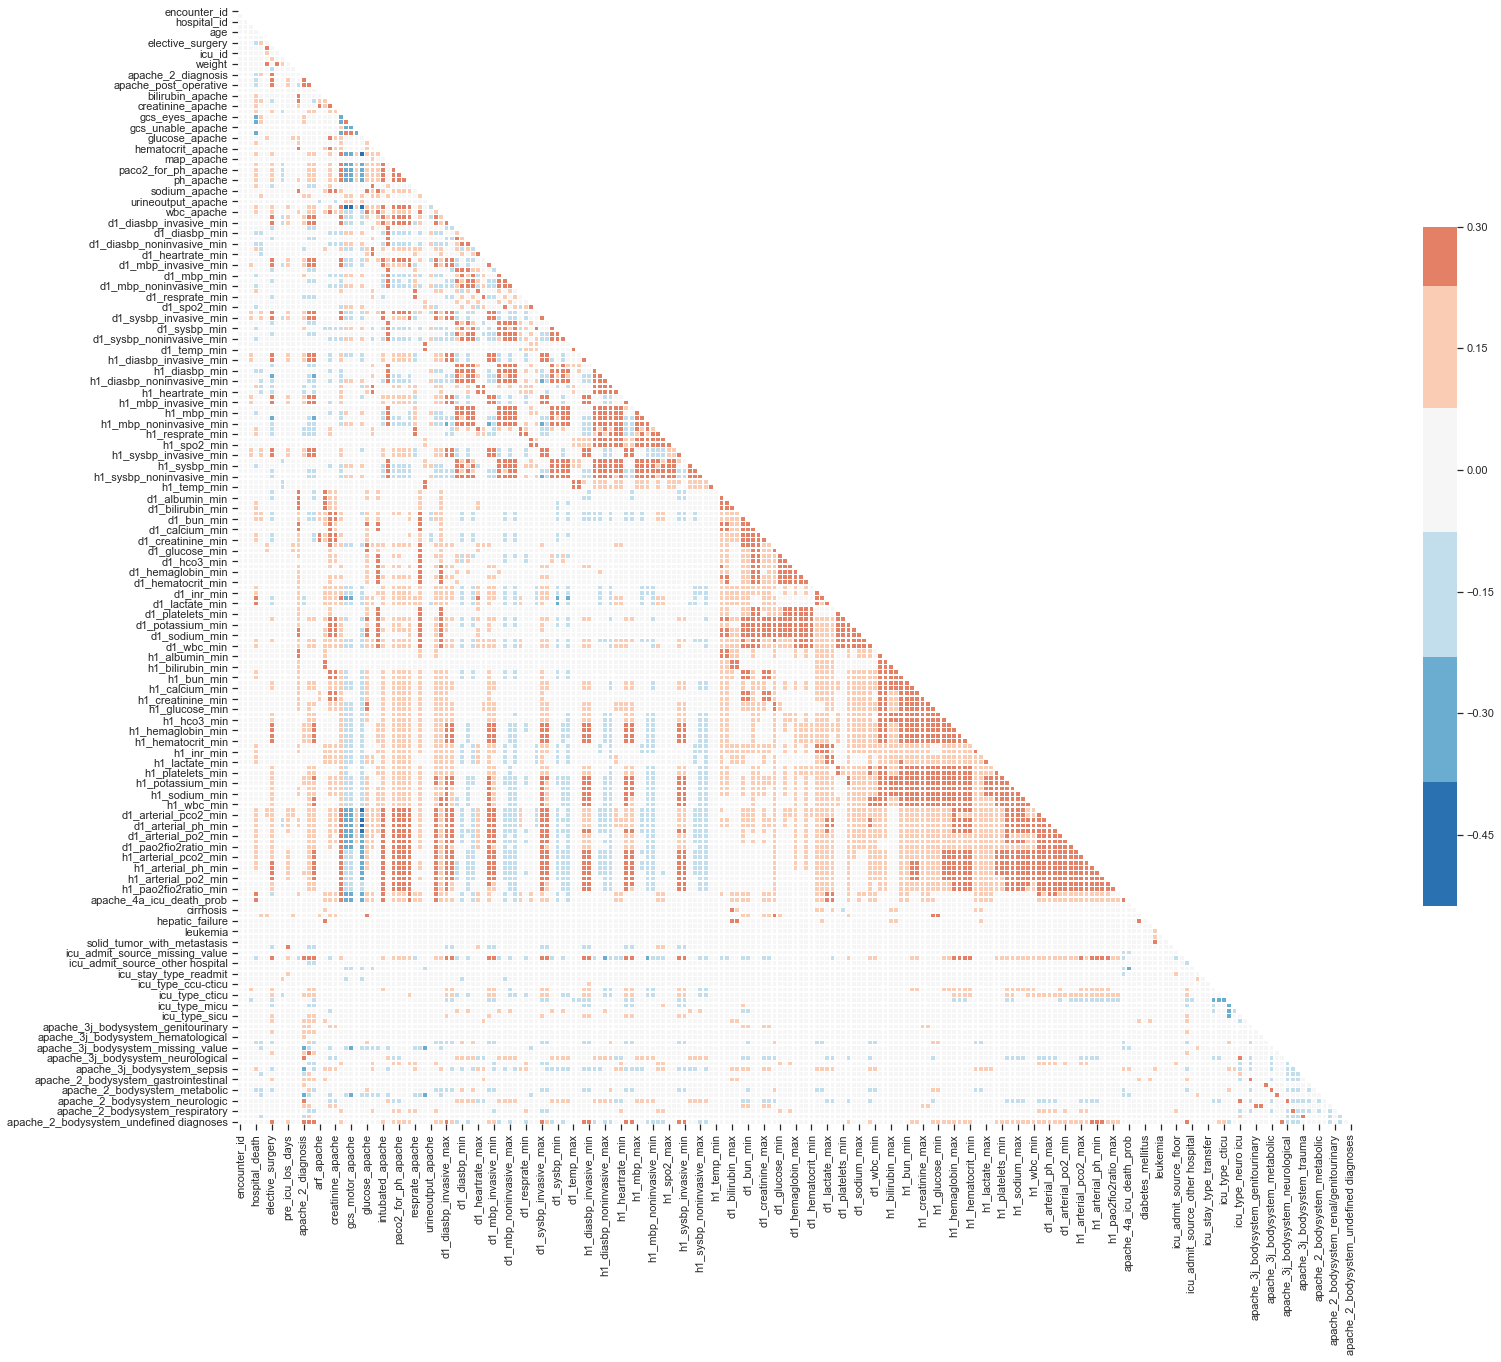

In [27]:
#Plot a correlation matrix heat map for the most correlated features to a hospital death
#generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))
# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 20,sep = 20, as_cmap=True)
cmap = sns.color_palette("RdBu_r", 7)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,cmap=cmap,mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#This isn't very helpful!  It's too big. 

# Prepare for Machine Learning

In [28]:
#Pop out the columns that are only identifiers  ie. encounter and patient id 
# These can be merged back into the result later
identifiers_train = df_train[['encounter_id','patient_id']]
identifiers_train.head()

,encounter_id,patient_id
0,66154.0,25312.0
1,114252.0,59342.0
2,119783.0,50777.0
3,79267.0,46918.0
4,92056.0,34377.0


In [29]:
identifiers_test = df_test[['encounter_id','patient_id']]
identifiers_test.head()

,encounter_id,patient_id
0,2.0,127112.0
1,5.0,130737.0
2,7.0,101458.0
3,8.0,48067.0
4,10.0,25865.0


In [30]:
train_features = list(most_corr_columns.index)
print(train_features)

['hospital_death', 'd1_lactate_min', 'd1_lactate_max', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'ventilated_apache', 'fio2_apache', 'd1_arterial_ph_max', 'd1_arterial_pco2_max', 'd1_arterial_ph_min', 'd1_arterial_po2_max', 'ph_apache', 'intubated_apache', 'd1_arterial_pco2_min', 'd1_bun_max', 'h1_lactate_min', 'h1_lactate_max', 'paco2_for_ph_apache', 'paco2_apache', 'd1_bun_min', 'd1_heartrate_max', 'd1_inr_max', 'h1_inr_max', 'bun_apache', 'd1_arterial_po2_min', 'pao2_apache', 'd1_inr_min', 'h1_inr_min', 'd1_pao2fio2ratio_max', 'd1_bilirubin_max', 'd1_diasbp_noninvasive_min', 'd1_mbp_noninvasive_min', 'd1_diasbp_min', 'd1_sysbp_noninvasive_min', 'd1_spo2_min', 'd1_mbp_min', 'd1_sysbp_min', 'gcs_verbal_apache', 'gcs_eyes_apache', 'gcs_motor_apache']


In [31]:
X = df_train[train_features].drop([target_col], axis = 1)  #drop off the column to predict
y = df_train[target_col].values.reshape(-1,1) #Only the target column

In [32]:
X.head()

,d1_lactate_min,d1_lactate_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,ventilated_apache,fio2_apache,d1_arterial_ph_max,d1_arterial_pco2_max,d1_arterial_ph_min,d1_arterial_po2_max,ph_apache,intubated_apache,d1_arterial_pco2_min,d1_bun_max,h1_lactate_min,h1_lactate_max,paco2_for_ph_apache,paco2_apache,d1_bun_min,d1_heartrate_max,d1_inr_max,h1_inr_max,bun_apache,d1_arterial_po2_min,pao2_apache,d1_inr_min,h1_inr_min,d1_pao2fio2ratio_max,d1_bilirubin_max,d1_diasbp_noninvasive_min,d1_mbp_noninvasive_min,d1_diasbp_min,d1_sysbp_noninvasive_min,d1_spo2_min,d1_mbp_min,d1_sysbp_min,gcs_verbal_apache,gcs_eyes_apache,gcs_motor_apache
0,1.0,1.3,0.10,0.05,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,31.0,0.0,0.0,0.0,0.0,30.0,119.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.4,37.0,46.0,37.0,73.0,74.0,46.0,73.0,4.0,3.0,6.0
1,3.5,3.5,0.47,0.29,1.0,1.0,7.45,37.0,7.45,51.0,7.45,0.0,37.0,11.0,3.5,3.5,37.0,37.0,9.0,118.0,1.3,1.3,9.0,51.0,51.0,1.3,1.3,54.8,0.5,31.0,38.0,31.0,67.0,70.0,38.0,67.0,1.0,1.0,3.0
2,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,68.0,48.0,105.0,91.0,68.0,105.0,5.0,3.0,6.0
3,0.0,0.0,0.04,0.03,1.0,0.6,7.44,37.0,7.34,337.0,7.39,1.0,27.0,0.0,0.0,0.0,30.0,30.0,0.0,116.0,1.6,1.6,0.0,102.0,142.0,1.1,1.1,342.5,0.0,42.0,84.0,42.0,84.0,95.0,84.0,84.0,5.0,4.0,6.0
4,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,90.0,57.0,120.0,96.0,90.0,120.0,0.0,0.0,0.0


In [33]:
print(X.shape, y.shape)

(91713, 39) (91713, 1)


In [34]:
# Use train_test_split to create training and testing data from our "train" dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Random Forest Classifier

In [35]:
y_train.shape

(68784, 1)

In [36]:
# Fit regression model
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=39, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=42)
model = rf
model.fit(X_train, y_train.ravel())
predictions = model.predict(X_test)

training_score = model.score(X_train, y_train.ravel())
testing_score = model.score(X_test, y_test.ravel())
#y_score = model.predict_proba(y_test.ravel())

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")
#print(y_score)

Training Score: 0.9999273086764364
Testing Score: 0.927428147760478


In [37]:
print(model.feature_importances_)

[0.05091085 0.02021356 0.08623375 0.17101156 0.00581821 0.0086005
 0.02081347 0.02026326 0.02049158 0.01943519 0.01457589 0.00173099
 0.0198444  0.02693015 0.00511059 0.00507096 0.00787892 0.00831839
 0.03420017 0.0531144  0.01050238 0.01052557 0.03029085 0.02068241
 0.01253354 0.01064916 0.01050752 0.01877169 0.02811911 0.02331842
 0.02341679 0.02572396 0.02860837 0.05282333 0.0255895  0.03437652
 0.01159513 0.01105652 0.01034243]


In [38]:
# for feature, importance in dict(zip(train_features,model.feature_importances_)):
#     print(feature)

importances = dict(zip(train_features,model.feature_importances_))
for f, i in sorted(importances.items(), key = lambda item: item[1], reverse = True):
    print(f, i)

# best_features = []
# for f, i in sorted(importances.items(), key = lambda item: item[1], reverse = True):
#     if i > .009:
#         best_features.append(f)
        
# print(best_features)
        

apache_4a_hospital_death_prob 0.17101156152274782
d1_lactate_max 0.08623375029207625
d1_bun_min 0.05311440075339725
d1_sysbp_noninvasive_min 0.05282332916431507
hospital_death 0.050910851839749575
d1_mbp_min 0.03437652447768796
paco2_apache 0.03420016749051595
h1_inr_max 0.030290854881705236
d1_diasbp_min 0.02860837111584377
d1_pao2fio2ratio_max 0.028119110847584068
d1_arterial_pco2_min 0.02693015006905873
d1_mbp_noninvasive_min 0.025723962289805266
d1_spo2_min 0.02558949530036988
d1_diasbp_noninvasive_min 0.023416787874915825
d1_bilirubin_max 0.023318422216632703
fio2_apache 0.020813472358857096
bun_apache 0.02068240787937234
d1_arterial_pco2_max 0.020491582666469176
d1_arterial_ph_max 0.02026325737038159
d1_lactate_min 0.020213559062928564
intubated_apache 0.019844396878155233
d1_arterial_ph_min 0.019435191964658472
h1_inr_min 0.01877169173794778
d1_arterial_po2_max 0.014575890742550444
d1_arterial_po2_min 0.01253354330727995
d1_sysbp_min 0.011595133998971309
gcs_verbal_apache 0.0110

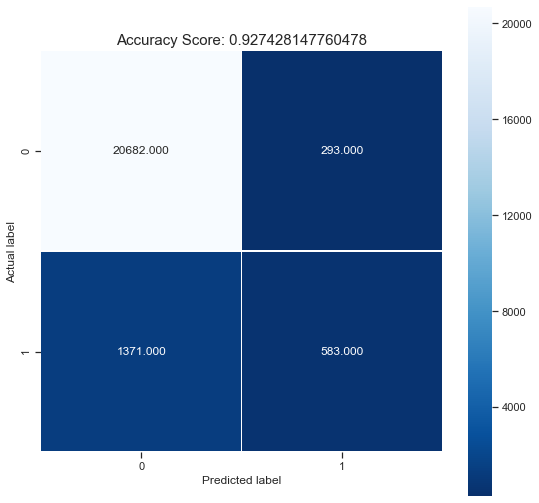

In [39]:
#Confusion Matrix (Seaborn)
#This is where we look at False positive, False negative etc. 

conf_matrix = metrics.confusion_matrix(y_test.ravel(), predictions )


#this is awesome:  https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
f = plt.figure(figsize=(9,9))
sns.heatmap(conf_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(testing_score)
plt.title(all_sample_title, size = 15);

In [40]:
f.savefig('../03_figures/RF_Figs/Confusion_matrix_RF'  + (str(date.today())))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.864


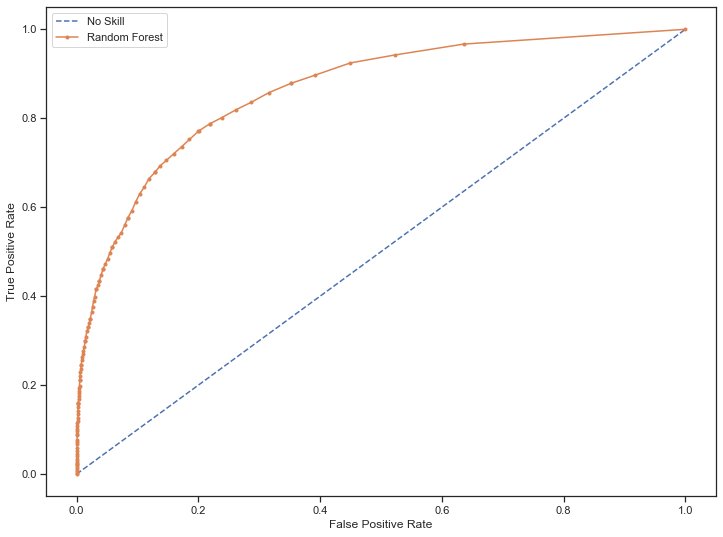

In [41]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
f2 = plt.figure(figsize = (12,9))
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [42]:
f2.savefig('../03_figures/RF_Figs/ROC_RF2'  + (str(date.today())))

# Train on full train dataset

In [41]:
#now, lets train on the entire training set to increase our sample size... 
# Fit random forest model

rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=39, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=42)
model = rf
model.fit(X, y.ravel())
predictions = model.predict(X)

training_score = model.score(X, y.ravel())

print(f"Training Score: {training_score}")

Training Score: 0.9998800606239028


# Make Predictions

In [42]:
print(target_col)

hospital_death


In [43]:
df_test = df_test[train_features].drop([target_col], axis = 1)  #drop off the column to predict

In [44]:
df_test.head()

,d1_lactate_min,d1_lactate_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,ventilated_apache,fio2_apache,d1_arterial_ph_max,d1_arterial_pco2_max,d1_arterial_ph_min,d1_arterial_po2_max,ph_apache,intubated_apache,d1_arterial_pco2_min,d1_bun_max,h1_lactate_min,h1_lactate_max,paco2_for_ph_apache,paco2_apache,d1_bun_min,d1_heartrate_max,d1_inr_max,h1_inr_max,bun_apache,d1_arterial_po2_min,pao2_apache,d1_inr_min,h1_inr_min,d1_pao2fio2ratio_max,d1_bilirubin_max,d1_diasbp_noninvasive_min,d1_mbp_noninvasive_min,d1_diasbp_min,d1_sysbp_noninvasive_min,d1_spo2_min,d1_mbp_min,d1_sysbp_min,gcs_verbal_apache,gcs_eyes_apache,gcs_motor_apache
0,0.0,0.0,0.13,0.08,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,19.0,0.0,0.0,0.0,0.0,19.0,100.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.00,0.0,51.0,60.0,51.0,79.0,96.0,60.0,79.0,1.0,2.0,5.0
1,0.0,0.0,0.09,0.03,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,12.0,0.0,0.0,0.0,0.0,12.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.6,31.0,53.0,31.0,83.0,90.0,53.0,83.0,4.0,4.0,6.0
2,0.0,0.0,0.03,0.02,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,22.0,0.0,0.0,0.0,0.0,19.0,117.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,57.0,0.0,95.0,71.0,102.0,1.0,2.0,5.0
3,0.8,0.8,0.19,0.17,1.0,0.7,7.37,36.0,7.35,142.0,7.35,1.0,36.0,24.0,0.0,0.0,36.0,36.0,24.0,111.0,1.4,1.4,24.0,57.0,142.0,1.4,1.4,202.86,0.8,42.0,48.0,42.0,69.0,92.0,48.0,69.0,1.0,4.0,6.0
4,0.0,0.0,0.50,0.42,1.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,11.0,0.0,0.0,0.0,0.0,9.0,94.0,1.0,1.0,11.0,0.0,0.0,1.0,1.0,0.00,0.4,24.0,37.0,24.0,66.0,95.0,37.0,66.0,1.0,1.0,4.0


In [45]:
#Make new prediction on the df_test data
#df_test[target_col] = model.predict(df_test)
df_test[target_col] = model.predict_proba(df_test)[:,1]

In [48]:
#add the identifier "encounter_id" back in
df_test['encounter_id'] = identifiers_test['encounter_id']

In [49]:
df_test.head()

,d1_lactate_min,d1_lactate_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,ventilated_apache,fio2_apache,d1_arterial_ph_max,d1_arterial_pco2_max,d1_arterial_ph_min,d1_arterial_po2_max,ph_apache,intubated_apache,d1_arterial_pco2_min,d1_bun_max,h1_lactate_min,h1_lactate_max,paco2_for_ph_apache,paco2_apache,d1_bun_min,d1_heartrate_max,d1_inr_max,h1_inr_max,bun_apache,d1_arterial_po2_min,pao2_apache,d1_inr_min,h1_inr_min,d1_pao2fio2ratio_max,d1_bilirubin_max,d1_diasbp_noninvasive_min,d1_mbp_noninvasive_min,d1_diasbp_min,d1_sysbp_noninvasive_min,d1_spo2_min,d1_mbp_min,d1_sysbp_min,gcs_verbal_apache,gcs_eyes_apache,gcs_motor_apache,hospital_death,encounter_id
0,0.0,0.0,0.13,0.08,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,19.0,0.0,0.0,0.0,0.0,19.0,100.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.00,0.0,51.0,60.0,51.0,79.0,96.0,60.0,79.0,1.0,2.0,5.0,0.03,2.0
1,0.0,0.0,0.09,0.03,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,12.0,0.0,0.0,0.0,0.0,12.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.6,31.0,53.0,31.0,83.0,90.0,53.0,83.0,4.0,4.0,6.0,0.01,5.0
2,0.0,0.0,0.03,0.02,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,22.0,0.0,0.0,0.0,0.0,19.0,117.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,57.0,0.0,95.0,71.0,102.0,1.0,2.0,5.0,0.06,7.0
3,0.8,0.8,0.19,0.17,1.0,0.7,7.37,36.0,7.35,142.0,7.35,1.0,36.0,24.0,0.0,0.0,36.0,36.0,24.0,111.0,1.4,1.4,24.0,57.0,142.0,1.4,1.4,202.86,0.8,42.0,48.0,42.0,69.0,92.0,48.0,69.0,1.0,4.0,6.0,0.06,8.0
4,0.0,0.0,0.50,0.42,1.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,11.0,0.0,0.0,0.0,0.0,9.0,94.0,1.0,1.0,11.0,0.0,0.0,1.0,1.0,0.00,0.4,24.0,37.0,24.0,66.0,95.0,37.0,66.0,1.0,1.0,4.0,0.52,10.0


In [50]:
#Convert encounter_id to int32
df_test['encounter_id'] = pd.to_numeric(df_test['encounter_id'],downcast = 'integer')

In [51]:
output = df_test[['encounter_id','hospital_death']]
output.head()

,encounter_id,hospital_death
0,2,0.03
1,5,0.01
2,7,0.06
3,8,0.06
4,10,0.52


In [52]:
df_test['encounter_id'].dtype

dtype('int32')

In [53]:
output.to_csv("../06_submissions/" + str(date.today()) + "_FINAL_RF2" + ".csv", index=False)